In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models
from torchvision.models.vgg import VGG
from sklearn.metrics import confusion_matrix
import pandas as pd
import scipy.misc
import random
import sys

if '/opt/ros/kinetic/lib/python2.7/dist-packages' in sys.path:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
import cv2

from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from matplotlib import pyplot as plt
import numpy as np
import time
import os

## Define FCN16s model for deconvolution layers

In [2]:
class FCN16s(nn.Module):

    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace = True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)

        score = self.relu(self.deconv1(x5))               # size=(N, 512, x.H/16, x.W/16)
        score = self.bn1(score + x4)                      # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.bn2(self.relu(self.deconv2(score)))  # size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)
        
        return score

## Define VGG16 for convolution layers

In [3]:
class VGGNet(VGG):
    def __init__(self, pretrained=True, model='vgg16', requires_grad=True, remove_fc=True, show_params=False):
        super().__init__(make_layers(cfg[model]))
        self.ranges = ranges[model]

        if pretrained:
            exec("self.load_state_dict(models.%s(pretrained=True).state_dict())" % model)

        if not requires_grad:
            for param in super().parameters():
                param.requires_grad = False

        if remove_fc:  # delete redundant fully-connected layer params, can save memory
            del self.classifier

        if show_params:
            for name, param in self.named_parameters():
                print(name, param.size())

    def forward(self, x):
        output = {}

        # get the output of each maxpooling layer (5 maxpool in VGG net)
        for idx in range(len(self.ranges)):
            for layer in range(self.ranges[idx][0], self.ranges[idx][1]):      
                x = self.features[layer](x)
            output["x%d"%(idx+1)] = x
        return output

In [4]:
ranges = {
    'vgg11': ((0, 3), (3, 6),  (6, 11),  (11, 16), (16, 21)),
    'vgg13': ((0, 5), (5, 10), (10, 15), (15, 20), (20, 25)),
    'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31)),
    'vgg19': ((0, 5), (5, 10), (10, 19), (19, 28), (28, 37))
}

# cropped version from https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

## Define training parameter

In [5]:
batch_size = 6
epochs     = 100 #500
lr         = 1e-4
momentum   = 0
w_decay    = 1e-5
step_size  = 50
gamma      = 0.5
model_use  = "barcode" # "products_20" "mini_competition"
n_class = 8

## Define path, directory trainning environment

In [6]:
# get data
data_dir  = os.path.join("data", model_use)
if not os.path.exists(data_dir):
    print("Data not found!")
# create dir for model
model_dir = os.path.join("models", model_use)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
# create dir for score
score_dir = os.path.join("scores", model_use)
if not os.path.exists(score_dir):
    os.makedirs(score_dir)

use_gpu = torch.cuda.is_available()
num_gpu = list(range(torch.cuda.device_count()))

vgg_model = VGGNet(requires_grad=True, remove_fc=True)
fcn_model = FCN16s(pretrained_net=vgg_model, n_class=n_class)
#use_gpu = False
if use_gpu:
    ts = time.time()
    vgg_model = vgg_model.cuda()
    fcn_model = fcn_model.cuda()
    fcn_model = nn.DataParallel(fcn_model, device_ids=num_gpu)
    print("Finish cuda loading, time elapsed {}".format(time.time() - ts))

Finish cuda loading, time elapsed 1.4225530624389648


## Visualize model

In [7]:
print(fcn_model)
params = list(fcn_model.parameters())

DataParallel(
  (module): FCN16s(
    (pretrained_net): VGGNet(
      (features): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace)
        (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace)
        (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (13): ReLU(inplace)
        (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  

HW: Finish Dataset class
-------------

``torch.utils.data.Dataset`` is an abstract class representing a
dataset.
Your custom dataset should inherit ``Dataset`` and override the following
methods:

-  ``__len__`` so that ``len(dataset)`` returns the size of the dataset.
-  ``__getitem__`` to support the indexing such that ``dataset[i]`` can
   be used to get $i$\ th sample

Let's create a dataset class for our face landmarks dataset. We will
read the csv in ``__init__`` but leave the reading of images to
``__getitem__``. This is memory efficient because all the images are not
stored in the memory at once but read as required.



In [9]:
means     = np.array([103.939, 116.779, 123.68]) / 255. # mean of three channels in the order of BGR
h, w      = 480, 640
val_h     = h
val_w     = w
class product_dataset(Dataset):

    def __init__(self, csv_file, phase, n_class=n_class, flip_rate=0.):
        self.data      = pd.read_csv(csv_file)
        self.means     = means
        self.n_class   = n_class
        self.flip_rate = flip_rate
        if phase == 'train':
            self.flip_rate = 0.5

    def __len__(self):
        #Return length of data
        return len(self.data)
        
    def __getitem__(self, idx):
        #Use the string in self.data to read image and label 
        img_name   = self.data.iloc[idx, 0]
        img        = cv2.imread(os.path.join(data_dir, img_name),cv2.IMREAD_UNCHANGED)
        label_name = self.data.iloc[idx, 1]
        label      = cv2.imread(os.path.join(data_dir, label_name), cv2.IMREAD_GRAYSCALE)
        origin_img = img

        
        if random.random() < self.flip_rate:
            img   = np.fliplr(img)
            label = np.fliplr(label)

        #Transpose image from (height * width * channel) to (channel * height * width)
        
        # reduce mean
        img = img[:, :, ::-1]  # switch to BGR
        
        img = np.transpose(img, (2, 0, 1)) / 255.
        img[0] -= self.means[0]
        img[1] -= self.means[1]
        img[2] -= self.means[2]

        # convert to tensor
        img = torch.from_numpy(img.copy()).float()
        label = torch.from_numpy(label.copy()).long()

        # create one-hot encoding
        h, w = label.size()
        target = torch.zeros(self.n_class, h, w)

        if "3m" in img_name:
            target[1][label == 255] = 1
            label[label == 255] = 1
        if "andes" in img_name:
            target[2][label == 255] = 1
            label[label == 255] = 2
        if "cocacola" in img_name:
            target[3][label == 255] = 1
            label[label == 255] = 3
        if "crayola" in img_name:
            target[4][label == 255] = 1
            label[label == 255] = 4
        if "kotex" in img_name:
            target[5][label == 255] = 1
            label[label == 255] = 5
        if "libava" in img_name:
            target[6][label == 255] = 1
            label[label == 255] = 6
        target[0][label == 0] = 1
        
        
        target[7][label == 128] = 1
        label[label == 128] = 7
        
        
            
        sample = {'X': img, 'Y': target, 'l': label, 'origin': origin_img}

        return sample

## Define dataloader and optimizer

In [10]:
# initial dataloader for trainning and validation
train_file = os.path.join(data_dir, "train.csv")
val_file   = os.path.join(data_dir, "val.csv")
train_data = product_dataset(csv_file = train_file, phase = 'train')
val_data   = product_dataset(csv_file = val_file, phase = 'val', flip_rate = 0)
dataloader = DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = 0)
val_loader = DataLoader(val_data, batch_size = 4, num_workers = 0)

dataiter = iter(val_loader)

# define loss function
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.RMSprop(fcn_model.parameters(), lr = lr, momentum = momentum, weight_decay = w_decay)
# decay LR by a factor of 0.5 every step_size = 50 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size = step_size, gamma = gamma)  

## Train

In [11]:
def train():
    for epoch in range(epochs):
        fcn_model.train()
        scheduler.step()
        configs    = "FCNs_{}_batch{}_epoch{}_RMSprop_lr{}"\
            .format(model_use, batch_size, epoch, lr)
        model_path = os.path.join(model_dir, configs)
        
        ts = time.time()
        for iter, batch in enumerate(dataloader):
            optimizer.zero_grad()

            if use_gpu:
                inputs = Variable(batch['X'].cuda())
                labels = Variable(batch['Y'].cuda())
            else:
                inputs, labels = Variable(batch['X']), Variable(batch['Y'])

            outputs = fcn_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if iter % 10 == 0:
                print("epoch{}, iter{}, loss: {}".format(epoch, iter, loss.data[0]))
                
        loss_l.append(loss.data[0])
        print("Finish epoch {}, time elapsed {}".format(epoch, time.time() - ts))
        torch.save(fcn_model.state_dict(), model_path + '.pkl')

        val(epoch)

## Evaluation

In [12]:
def val(epoch):
    fcn_model.eval()
    TP = np.zeros(n_class-1, dtype = np.float128)
    FN = np.zeros(n_class-1, dtype = np.float128)
    FP = np.zeros(n_class-1, dtype = np.float128)
    total_ious = []
    pixel_accs = []
    for iter, batch in enumerate(val_loader):
        if use_gpu:
            inputs = Variable(batch['X'].cuda())
        else:
            inputs = Variable(batch['X'])

        output = fcn_model(inputs)
        output = output.data.cpu().numpy()

        N, _, h, w = output.shape
        pred = output.transpose(0, 2, 3, 1).reshape(-1, n_class).argmax(axis=1).reshape(N, h, w)

        target = batch['l'].cpu().numpy().reshape(N, h, w)
        for p, t in zip(pred, target):
            pixel_accs.append(pixel_acc(p, t))
            _TP, _FN, _FP =  analysis(p, t, h, w)
            TP += _TP[1:n_class]
            FN += _FN[1:n_class]
            FP += _FP[1:n_class]
            #print(TP,FN,FP)
            
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    ious = TP / (TP + FN + FP)
    fscore = 2*TP / (2*TP + FN + FP)
    total_ious = np.array(total_ious).T  # n_class * val_len
    pixel_accs = np.array(pixel_accs).mean()
    
    print("epoch{}, pix_acc: {}, meanIoU: {}, IoUs: {}, recall: {}, precision: {}, fscore: {}"\
          .format(epoch, pixel_accs, np.nanmean(ious), ious, recall, precision, fscore))
    iou_l.append(ious)
    fscore_l.append(fscore)
    f1 = open(score_dir + "/cls_acc_log.txt","a+")
    f1.write('epoch:'+ str(epoch) + ', pix_acc: ' + str(pixel_accs) + '\n' )
    f2 = open(score_dir + "/cls_iou_log.txt","a+")
    f2.write('epoch:'+ str(epoch) + ', class ious: ' + str(ious) + '\n' )
    f3 = open(score_dir + "/mean_iou_log.txt","a+")
    f3.write('epoch:'+ str(epoch) + ', mean IoU: ' + str(np.nanmean(ious)) + '\n' ) 
    f4 = open(score_dir + "/recall_log.txt","a+")
    f4.write('epoch:'+ str(epoch) + ', class recall: ' + str(recall) + '\n' )
    f5 = open(score_dir + "/precision_log.txt","a+")
    f5.write('epoch:'+ str(epoch) + ', class precision: ' + str(precision) + '\n' )    
    f6 = open(score_dir + "/fscore_log.txt","a+")
    f6.write('epoch:'+ str(epoch) + ', class fscore: ' + str(fscore) + '\n' )  
    

def analysis(pred, target, h, w):
    # TP, FN, FP, TN
    TP = np.zeros(n_class, dtype = np.float128)
    FN = np.zeros(n_class, dtype = np.float128)
    FP = np.zeros(n_class, dtype = np.float128)

    target = target.reshape(h * w)
    pred = pred.reshape(h * w)

    con_matrix = confusion_matrix(target, pred,labels = np.arange(0,n_class,1))
    con_matrix[0][0] = 0
    for i in range(0, n_class):
        for j in range(0, n_class):
            if i == j:
                TP[i] += con_matrix[i][j]
            if i != j:
                FP[j] += con_matrix[i][j]
                FN[i] += con_matrix[i][j]
    return TP, FN, FP
                
def pixel_acc(pred, target):
    correct = (pred == target).sum()
    total   = (target == target).sum()
    return correct / total

In [13]:
loss_l = []
fscore_l = []
iou_l = []
train()

/home/andyser/.local/lib/python3.5/site-packages/ipykernel_launcher.py:24: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch0, iter0, loss: 0.7089698910713196
epoch0, iter10, loss: 0.6917617917060852
epoch0, iter20, loss: 0.6878178715705872
epoch0, iter30, loss: 0.6846494674682617
epoch0, iter40, loss: 0.6818503737449646
epoch0, iter50, loss: 0.679439902305603
epoch0, iter60, loss: 0.6771388053894043
epoch0, iter70, loss: 0.674660861492157
epoch0, iter80, loss: 0.6723388433456421
epoch0, iter90, loss: 0.6701791882514954
epoch0, iter100, loss: 0.6678301095962524
epoch0, iter110, loss: 0.6656169295310974
epoch0, iter120, loss: 0.6632291674613953
epoch0, iter130, loss: 0.6609081625938416
epoch0, iter140, loss: 0.658486545085907
epoch0, iter150, loss: 0.6562216877937317
epoch0, iter160, loss: 0.6535472273826599
epoch0, iter170, loss: 0.651322603225708
epoch0, iter180, loss: 0.649088442325592
epoch0, iter190, loss: 0.646564781665802
epoch0, iter200, loss: 0.6440480947494507
epoch0, iter210, loss: 0.6417037844657898
epoch0, iter220, loss: 0.6390796899795532
epoch0, iter230, loss: 0.6366110444068909
epoch0, i

/home/andyser/.local/lib/python3.5/site-packages/ipykernel_launcher.py:26: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Finish epoch 0, time elapsed 1016.7675170898438
epoch0, pix_acc: 0.9971618831858916, meanIoU: 0.04125058316417424, IoUs: [ 0.03059728  0.040743896  0.09514898  0.010106593  0.016407148
  0.083512615  0.012237571], recall: [ 0.13734853  0.058482457  0.35431499  0.011903655  0.019116553  0.22852847
  0.012903784], precision: [ 0.037876067  0.11842155  0.11510809  0.062745098  0.10375211  0.11630049
  0.19161079], fscore: [ 0.059377761  0.07829764  0.17376445  0.020010943  0.032284598  0.15415162
  0.024179247]
epoch1, iter0, loss: 0.295897901058197
epoch1, iter10, loss: 0.2929846942424774
epoch1, iter20, loss: 0.2897883951663971
epoch1, iter30, loss: 0.2872562110424042
epoch1, iter40, loss: 0.28454282879829407
epoch1, iter50, loss: 0.2809988558292389
epoch1, iter60, loss: 0.2780033051967621
epoch1, iter70, loss: 0.27531272172927856
epoch1, iter80, loss: 0.27241677045822144
epoch1, iter90, loss: 0.2694757580757141
epoch1, iter100, loss: 0.2668965458869934
epoch1, iter110, loss: 0.26380783

epoch2, iter340, loss: 0.02900364249944687
epoch2, iter350, loss: 0.02792884223163128
epoch2, iter360, loss: 0.026614464819431305
epoch2, iter370, loss: 0.026444533839821815
epoch2, iter380, loss: 0.02675607055425644
epoch2, iter390, loss: 0.02528984472155571
epoch2, iter400, loss: 0.02553337998688221
epoch2, iter410, loss: 0.024277018383145332
epoch2, iter420, loss: 0.02417348325252533
epoch2, iter430, loss: 0.023699268698692322
epoch2, iter440, loss: 0.023045390844345093
epoch2, iter450, loss: 0.023247474804520607
epoch2, iter460, loss: 0.02292804606258869
epoch2, iter470, loss: 0.022408830001950264
epoch2, iter480, loss: 0.021694881841540337
epoch2, iter490, loss: 0.021145092323422432
epoch2, iter500, loss: 0.020877400413155556
epoch2, iter510, loss: 0.02022307552397251
epoch2, iter520, loss: 0.020347287878394127
epoch2, iter530, loss: 0.02064690738916397
epoch2, iter540, loss: 0.019360098987817764
epoch2, iter550, loss: 0.019058916717767715
epoch2, iter560, loss: 0.0183571353554725

epoch3, iter740, loss: 0.0027281471993774176
epoch3, iter750, loss: 0.003350186161696911
epoch3, iter760, loss: 0.004198855254799128
epoch3, iter770, loss: 0.0017389035783708096
epoch3, iter780, loss: 0.0016253878129646182
epoch3, iter790, loss: 0.0014945087023079395
epoch3, iter800, loss: 0.002260879846289754
epoch3, iter810, loss: 0.0015091835521161556
epoch3, iter820, loss: 0.0024415883235633373
epoch3, iter830, loss: 0.002295789076015353
epoch3, iter840, loss: 0.0019461163319647312
epoch3, iter850, loss: 0.0032510138116776943
epoch3, iter860, loss: 0.0017121861455962062
epoch3, iter870, loss: 0.0023471578024327755
epoch3, iter880, loss: 0.0017926133004948497
epoch3, iter890, loss: 0.0016629548044875264
epoch3, iter900, loss: 0.0011225781636312604
epoch3, iter910, loss: 0.002645815024152398
epoch3, iter920, loss: 0.0036680344492197037
epoch3, iter930, loss: 0.0011659548617899418
epoch3, iter940, loss: 0.001497733173891902
epoch3, iter950, loss: 0.0011726943776011467
epoch3, iter960,

/home/andyser/.local/lib/python3.5/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


epoch3, pix_acc: 0.9980914306640624, meanIoU: 0.0979129349463228, IoUs: [ 0.013365171  0.21399177  0.0  4.6498652e-05  0.04968363  0.0  0.40830348], recall: [ 0.014577681  0.35737839  0.0  4.6498652e-05  0.054603261  0.0  0.4379696], precision: [ 0.1384404  0.34783549  0.0  1.0  0.35543813  nan  0.85771004], fscore: [ 0.026377798  0.35254237  0.0  9.2992979e-05  0.094664008  0.0  0.57985155]
epoch4, iter0, loss: 0.002134827198460698
epoch4, iter10, loss: 0.0015375073999166489
epoch4, iter20, loss: 0.0011436896165832877
epoch4, iter30, loss: 0.0025986202526837587
epoch4, iter40, loss: 0.0011666989885270596
epoch4, iter50, loss: 0.0011906754225492477
epoch4, iter60, loss: 0.0023508532904088497
epoch4, iter70, loss: 0.0012977102305740118
epoch4, iter80, loss: 0.0007940297946333885
epoch4, iter90, loss: 0.0017468525329604745
epoch4, iter100, loss: 0.0017176424153149128
epoch4, iter110, loss: 0.0005170950316824019
epoch4, iter120, loss: 0.0017828617710620165
epoch4, iter130, loss: 0.0016050

epoch5, iter290, loss: 0.0007678939145989716
epoch5, iter300, loss: 0.0008967480389401317
epoch5, iter310, loss: 0.0007727211923338473
epoch5, iter320, loss: 0.00039309568819589913
epoch5, iter330, loss: 0.0008790510473772883
epoch5, iter340, loss: 0.0018188311951234937
epoch5, iter350, loss: 0.0010991988237947226
epoch5, iter360, loss: 0.0025156461633741856
epoch5, iter370, loss: 0.0004727221676148474
epoch5, iter380, loss: 0.0006507175858132541
epoch5, iter390, loss: 0.0010359474690631032
epoch5, iter400, loss: 0.00046168407425284386
epoch5, iter410, loss: 0.0004402267513796687
epoch5, iter420, loss: 0.0014756228774785995
epoch5, iter430, loss: 0.0015489995712414384
epoch5, iter440, loss: 0.000506301352288574
epoch5, iter450, loss: 0.0007080308278091252
epoch5, iter460, loss: 0.0009038621792569757
epoch5, iter470, loss: 0.0009738507214933634
epoch5, iter480, loss: 0.000851584889460355
epoch5, iter490, loss: 0.001015475601889193
epoch5, iter500, loss: 0.0005988962366245687
epoch5, ite

epoch6, iter660, loss: 0.0004559739609248936
epoch6, iter670, loss: 0.0009111510589718819
epoch6, iter680, loss: 0.0010121180675923824
epoch6, iter690, loss: 0.0008096370147541165
epoch6, iter700, loss: 0.0008056322694756091
epoch6, iter710, loss: 0.0005239254096522927
epoch6, iter720, loss: 0.00037386867916211486
epoch6, iter730, loss: 0.0009273332543671131
epoch6, iter740, loss: 0.0007820245227776468
epoch6, iter750, loss: 0.0015333715127781034
epoch6, iter760, loss: 0.0012375894002616405
epoch6, iter770, loss: 0.0010929666459560394
epoch6, iter780, loss: 0.00045903108548372984
epoch6, iter790, loss: 0.0011255515273660421
epoch6, iter800, loss: 0.0020594929810613394
epoch6, iter810, loss: 0.000544463749974966
epoch6, iter820, loss: 0.0007832186529412866
epoch6, iter830, loss: 0.0007575761992484331
epoch6, iter840, loss: 0.0009080747840926051
epoch6, iter850, loss: 0.0006263139075599611
epoch6, iter860, loss: 0.00025049038231372833
epoch6, iter870, loss: 0.0005054269568063319
epoch6, 

epoch7, iter1030, loss: 0.0007051918655633926
epoch7, iter1040, loss: 0.0007521739462390542
epoch7, iter1050, loss: 0.0012353326892480254
epoch7, iter1060, loss: 0.001265882165171206
epoch7, iter1070, loss: 0.00015690230065956712
epoch7, iter1080, loss: 0.0006387651083059609
epoch7, iter1090, loss: 0.0006730995955877006
epoch7, iter1100, loss: 0.0009268972207792103
epoch7, iter1110, loss: 0.0001758142316248268
epoch7, iter1120, loss: 0.000720881624147296
epoch7, iter1130, loss: 0.00019977970805484802
epoch7, iter1140, loss: 0.0003237136406823993
epoch7, iter1150, loss: 0.0008131381473504007
epoch7, iter1160, loss: 0.0009535966673865914
epoch7, iter1170, loss: 0.0009915339760482311
epoch7, iter1180, loss: 0.0004934424068778753
epoch7, iter1190, loss: 0.0005634414847008884
epoch7, iter1200, loss: 0.0009402222349308431
epoch7, iter1210, loss: 0.0006143290665932
epoch7, iter1220, loss: 0.0007249578484334052
epoch7, iter1230, loss: 0.0007862964412197471
epoch7, iter1240, loss: 0.00106576911

epoch9, iter0, loss: 0.0006418430712074041
epoch9, iter10, loss: 0.0006080361199565232
epoch9, iter20, loss: 0.00013839569874107838
epoch9, iter30, loss: 0.0013243730645626783
epoch9, iter40, loss: 0.0005067625897936523
epoch9, iter50, loss: 0.0014073662459850311
epoch9, iter60, loss: 0.0006633460870943964
epoch9, iter70, loss: 0.00042709033004939556
epoch9, iter80, loss: 0.0008260496542789042
epoch9, iter90, loss: 0.0009121639304794371
epoch9, iter100, loss: 0.0004436616727616638
epoch9, iter110, loss: 0.0015232327859848738
epoch9, iter120, loss: 0.0003437225241214037
epoch9, iter130, loss: 0.0013121564406901598
epoch9, iter140, loss: 0.0007009460241533816
epoch9, iter150, loss: 0.000934930401854217
epoch9, iter160, loss: 0.0004245614691171795
epoch9, iter170, loss: 0.0007399872411042452
epoch9, iter180, loss: 0.00042259827023372054
epoch9, iter190, loss: 0.0008792782900854945
epoch9, iter200, loss: 0.0005724075017496943
epoch9, iter210, loss: 0.0005729061085730791
epoch9, iter220, lo

epoch10, iter360, loss: 0.0008868237491697073
epoch10, iter370, loss: 0.0007783879991620779
epoch10, iter380, loss: 0.000416995317209512
epoch10, iter390, loss: 0.0010412265546619892
epoch10, iter400, loss: 0.0017184128519147635
epoch10, iter410, loss: 0.0005395337357185781
epoch10, iter420, loss: 0.0006825014716014266
epoch10, iter430, loss: 0.0005947701283730567
epoch10, iter440, loss: 0.00032482168171554804
epoch10, iter450, loss: 0.0003411998332012445
epoch10, iter460, loss: 0.00023473026521969587
epoch10, iter470, loss: 0.00022896002337802202
epoch10, iter480, loss: 0.0006284485571086407
epoch10, iter490, loss: 0.001114454003982246
epoch10, iter500, loss: 0.00041441689245402813
epoch10, iter510, loss: 0.0007961147930473089
epoch10, iter520, loss: 0.0006276679341681302
epoch10, iter530, loss: 0.0003291894099675119
epoch10, iter540, loss: 0.0009965950157493353
epoch10, iter550, loss: 0.0009138344903476536
epoch10, iter560, loss: 0.0006367841269820929
epoch10, iter570, loss: 0.002083

epoch11, iter690, loss: 0.0006184402154758573
epoch11, iter700, loss: 0.00031085917726159096
epoch11, iter710, loss: 0.0008531708153896034
epoch11, iter720, loss: 0.0009301549871452153
epoch11, iter730, loss: 0.0007739876746200025
epoch11, iter740, loss: 0.0005529294721782207
epoch11, iter750, loss: 0.00020381454669404775
epoch11, iter760, loss: 0.0004270802019163966
epoch11, iter770, loss: 0.0003076623543165624
epoch11, iter780, loss: 0.00034289807081222534
epoch11, iter790, loss: 0.0011452898615971208
epoch11, iter800, loss: 0.0004967646091245115
epoch11, iter810, loss: 0.0003721540269907564
epoch11, iter820, loss: 0.0002448504092171788
epoch11, iter830, loss: 0.0004525775439105928
epoch11, iter840, loss: 0.0007932874141260982
epoch11, iter850, loss: 0.0004190645122434944
epoch11, iter860, loss: 0.0006090993992984295
epoch11, iter870, loss: 0.000773741805460304
epoch11, iter880, loss: 0.0007666543242521584
epoch11, iter890, loss: 0.000538994965609163
epoch11, iter900, loss: 0.0008527

epoch12, iter1020, loss: 0.00014610249490942806
epoch12, iter1030, loss: 0.0003391852951608598
epoch12, iter1040, loss: 0.0003824869927484542
epoch12, iter1050, loss: 0.0006833844818174839
epoch12, iter1060, loss: 0.0001520989608252421
epoch12, iter1070, loss: 0.0008868445293046534
epoch12, iter1080, loss: 0.002143054036423564
epoch12, iter1090, loss: 0.0002720578049775213
epoch12, iter1100, loss: 0.0005837614298798144
epoch12, iter1110, loss: 0.0004469659470487386
epoch12, iter1120, loss: 0.0001643974392209202
epoch12, iter1130, loss: 0.0002547601470723748
epoch12, iter1140, loss: 0.00017906386347021908
epoch12, iter1150, loss: 0.0007929360144771636
epoch12, iter1160, loss: 0.0005423222319222987
epoch12, iter1170, loss: 0.00026641107979230583
epoch12, iter1180, loss: 0.00044370396062731743
epoch12, iter1190, loss: 0.0004935776232741773
epoch12, iter1200, loss: 0.00034020133898593485
epoch12, iter1210, loss: 0.0008048106101341546
epoch12, iter1220, loss: 0.0003088308440055698
epoch12, 

Finish epoch 13, time elapsed 991.7467579841614
epoch13, pix_acc: 0.9989425359987746, meanIoU: 0.619123740658475, IoUs: [ 0.51518039  0.66386388  0.66081467  0.59968746  0.66962116  0.67007874
  0.55461989], recall: [ 0.86055345  0.7429884  0.91878555  0.98140054  0.80541162  0.86752638
  0.6157209], precision: [ 0.56210571  0.86175927  0.7018084  0.60658141  0.79886207  0.74645849
  0.84823095], fscore: [ 0.68002515  0.79797859  0.79577172  0.74975578  0.80212347  0.80245167
  0.71351189]
epoch14, iter0, loss: 0.0008904507849365473
epoch14, iter10, loss: 0.0006393181974999607
epoch14, iter20, loss: 0.00039277455653063953
epoch14, iter30, loss: 0.0007172467885538936
epoch14, iter40, loss: 0.001016606343910098
epoch14, iter50, loss: 0.0003102892660535872
epoch14, iter60, loss: 0.00022085625096224248
epoch14, iter70, loss: 0.0002606352209113538
epoch14, iter80, loss: 0.00023493956541642547
epoch14, iter90, loss: 0.000482678267871961
epoch14, iter100, loss: 0.00011613597598625347
epoch14,

epoch15, iter220, loss: 0.0009480338194407523
epoch15, iter230, loss: 0.0007501956424675882
epoch15, iter240, loss: 0.00047269638162106276
epoch15, iter250, loss: 0.0006874476675875485
epoch15, iter260, loss: 0.0004965815460309386
epoch15, iter270, loss: 0.0005413817125372589
epoch15, iter280, loss: 0.00020198772836010903
epoch15, iter290, loss: 0.001457841950468719
epoch15, iter300, loss: 0.00045819286606274545
epoch15, iter310, loss: 0.0012408848851919174
epoch15, iter320, loss: 0.00042285898234695196
epoch15, iter330, loss: 0.0011384089011698961
epoch15, iter340, loss: 0.0005146248731762171
epoch15, iter350, loss: 0.00012775998038705438
epoch15, iter360, loss: 0.0011252887779846787
epoch15, iter370, loss: 0.000758702284656465
epoch15, iter380, loss: 0.0014330543344840407
epoch15, iter390, loss: 8.270856051240116e-05
epoch15, iter400, loss: 0.00027071923250332475
epoch15, iter410, loss: 0.00045587820932269096
epoch15, iter420, loss: 0.0002441753458697349
epoch15, iter430, loss: 5.135

epoch16, iter550, loss: 0.0005500129773281515
epoch16, iter560, loss: 0.0006407953333109617
epoch16, iter570, loss: 0.0002825252595357597
epoch16, iter580, loss: 0.00024283867969643325
epoch16, iter590, loss: 0.0005131940124556422
epoch16, iter600, loss: 0.0004534101171884686
epoch16, iter610, loss: 0.0005147140473127365
epoch16, iter620, loss: 0.0006206279504112899
epoch16, iter630, loss: 0.0003285832062829286
epoch16, iter640, loss: 0.0001792253169696778
epoch16, iter650, loss: 0.0010137488134205341
epoch16, iter660, loss: 0.0003157194296363741
epoch16, iter670, loss: 0.0004563996335491538
epoch16, iter680, loss: 0.0004590848402585834
epoch16, iter690, loss: 6.055136691429652e-05
epoch16, iter700, loss: 0.00023514445638284087
epoch16, iter710, loss: 0.0003993893333245069
epoch16, iter720, loss: 0.0003823245642706752
epoch16, iter730, loss: 0.0004481907526496798
epoch16, iter740, loss: 0.000571308599319309
epoch16, iter750, loss: 0.0008415537886321545
epoch16, iter760, loss: 0.0004095

epoch17, iter880, loss: 0.0004192143096588552
epoch17, iter890, loss: 0.0014536960516124964
epoch17, iter900, loss: 0.0005897225346416235
epoch17, iter910, loss: 0.00046335323713719845
epoch17, iter920, loss: 0.0006195887108333409
epoch17, iter930, loss: 0.0010834025451913476
epoch17, iter940, loss: 0.0003939964226447046
epoch17, iter950, loss: 0.0005083665600977838
epoch17, iter960, loss: 0.0010664482833817601
epoch17, iter970, loss: 0.00042690406553447247
epoch17, iter980, loss: 0.00046765798470005393
epoch17, iter990, loss: 0.0013121911324560642
epoch17, iter1000, loss: 0.0015798985259607434
epoch17, iter1010, loss: 0.0003527982335072011
epoch17, iter1020, loss: 0.0004439917393028736
epoch17, iter1030, loss: 0.0007122678216546774
epoch17, iter1040, loss: 0.00064796645892784
epoch17, iter1050, loss: 0.00022418743174057454
epoch17, iter1060, loss: 0.0006234694155864418
epoch17, iter1070, loss: 0.00041686350596137345
epoch17, iter1080, loss: 0.00043935159919783473
epoch17, iter1090, lo

epoch18, iter1200, loss: 0.0007685863529331982
epoch18, iter1210, loss: 0.0005170740187168121
epoch18, iter1220, loss: 0.000900636485312134
epoch18, iter1230, loss: 0.00043901693425141275
epoch18, iter1240, loss: 0.0003109363024123013
epoch18, iter1250, loss: 0.0006892033852636814
epoch18, iter1260, loss: 0.0007606061990372837
epoch18, iter1270, loss: 0.00030908334883861244
epoch18, iter1280, loss: 0.0010851057013496757
epoch18, iter1290, loss: 9.106002107728273e-05
epoch18, iter1300, loss: 0.0004948613932356238
epoch18, iter1310, loss: 0.00047772281686775386
epoch18, iter1320, loss: 0.0005454114289022982
epoch18, iter1330, loss: 0.00023944387794472277
Finish epoch 18, time elapsed 990.965842962265
epoch18, pix_acc: 0.999218277276731, meanIoU: 0.698108634506818, IoUs: [ 0.587506  0.76754894  0.6435277  0.74354352  0.718442  0.72956532
  0.69662696], recall: [ 0.79706999  0.85843429  0.68427694  0.93978425  0.8195089  0.81912942
  0.86815657], precision: [ 0.69083898  0.87878328  0.9152

epoch20, iter80, loss: 0.0005076102097518742
epoch20, iter90, loss: 8.818904461804777e-05
epoch20, iter100, loss: 0.0009309027809649706
epoch20, iter110, loss: 0.0004641241393983364
epoch20, iter120, loss: 0.0007371708634309471
epoch20, iter130, loss: 0.0005643098847940564
epoch20, iter140, loss: 0.00027505101752467453
epoch20, iter150, loss: 0.0005199077422730625
epoch20, iter160, loss: 0.0001313279353780672
epoch20, iter170, loss: 0.0004631428455468267
epoch20, iter180, loss: 0.00040234639891423285
epoch20, iter190, loss: 0.00028089917032048106
epoch20, iter200, loss: 0.00016748082998674363
epoch20, iter210, loss: 0.0006587313255295157
epoch20, iter220, loss: 0.00036283087683841586
epoch20, iter230, loss: 0.0004264846502337605
epoch20, iter240, loss: 0.0004222610732540488
epoch20, iter250, loss: 0.00038362210034392774
epoch20, iter260, loss: 0.0003081920731347054
epoch20, iter270, loss: 0.0016643463168293238
epoch20, iter280, loss: 0.0006028585485182703
epoch20, iter290, loss: 0.0003

epoch21, iter410, loss: 0.0002963370061479509
epoch21, iter420, loss: 0.00040540352347306907
epoch21, iter430, loss: 0.0005698838504031301
epoch21, iter440, loss: 0.0005076645757071674
epoch21, iter450, loss: 0.0005180620355531573
epoch21, iter460, loss: 0.00027784655685536563
epoch21, iter470, loss: 0.0004045139066874981
epoch21, iter480, loss: 0.0004136527713853866
epoch21, iter490, loss: 0.0006235254695639014
epoch21, iter500, loss: 0.00034956561285071075
epoch21, iter510, loss: 0.00023328157840296626
epoch21, iter520, loss: 0.00020183382730465382
epoch21, iter530, loss: 0.000456094101537019
epoch21, iter540, loss: 0.0005491481861099601
epoch21, iter550, loss: 0.00046087210648693144
epoch21, iter560, loss: 0.0003380334528628737
epoch21, iter570, loss: 0.00033043682924471796
epoch21, iter580, loss: 0.00012080752640031278
epoch21, iter590, loss: 0.00028573282179422677
epoch21, iter600, loss: 0.0005815168260596693
epoch21, iter610, loss: 0.0004174037603661418
epoch21, iter620, loss: 0.

epoch22, iter730, loss: 0.001088285818696022
epoch22, iter740, loss: 0.000341344770276919
epoch22, iter750, loss: 0.0002618502185214311
epoch22, iter760, loss: 9.644911187933758e-05
epoch22, iter770, loss: 0.00023399449128191918
epoch22, iter780, loss: 0.0009228648850694299
epoch22, iter790, loss: 0.0006727363215759397
epoch22, iter800, loss: 0.0005880732787773013
epoch22, iter810, loss: 0.0006299675442278385
epoch22, iter820, loss: 0.00023449824948329479
epoch22, iter830, loss: 0.0011168624041602015
epoch22, iter840, loss: 0.0004662988940253854
epoch22, iter850, loss: 0.0010003398638218641
epoch22, iter860, loss: 0.00016426232468802482
epoch22, iter870, loss: 0.0002927757450379431
epoch22, iter880, loss: 0.00029274026746861637
epoch22, iter890, loss: 0.0002203859039582312
epoch22, iter900, loss: 0.0006416486576199532
epoch22, iter910, loss: 0.0006172224530018866
epoch22, iter920, loss: 0.0002423685509711504
epoch22, iter930, loss: 0.0002776703331619501
epoch22, iter940, loss: 0.000308

epoch23, iter1050, loss: 0.0005517269019037485
epoch23, iter1060, loss: 0.0005768425762653351
epoch23, iter1070, loss: 0.0004023874644190073
epoch23, iter1080, loss: 0.0011884903069585562
epoch23, iter1090, loss: 0.00030408959719352424
epoch23, iter1100, loss: 0.00020265707280486822
epoch23, iter1110, loss: 0.0004755257978104055
epoch23, iter1120, loss: 0.00036975229158997536
epoch23, iter1130, loss: 0.00029319158056750894
epoch23, iter1140, loss: 0.0004053534066770226
epoch23, iter1150, loss: 0.000644566782284528
epoch23, iter1160, loss: 0.0001832042180467397
epoch23, iter1170, loss: 0.00014597219706047326
epoch23, iter1180, loss: 0.0009197567705996335
epoch23, iter1190, loss: 0.0004702885926235467
epoch23, iter1200, loss: 0.00046344136353582144
epoch23, iter1210, loss: 0.00034066004445776343
epoch23, iter1220, loss: 0.0003494538541417569
epoch23, iter1230, loss: 0.00031596486223861575
epoch23, iter1240, loss: 0.000627953268121928
epoch23, iter1250, loss: 0.0001974769838852808
epoch23

epoch25, iter0, loss: 0.00021503078460227698
epoch25, iter10, loss: 0.0006715097115375102
epoch25, iter20, loss: 0.00032397423638030887
epoch25, iter30, loss: 0.0007435990846715868
epoch25, iter40, loss: 0.0002971020876429975
epoch25, iter50, loss: 0.000123384699691087
epoch25, iter60, loss: 0.000340362690621987
epoch25, iter70, loss: 0.00045822461834177375
epoch25, iter80, loss: 0.0007079520146362484
epoch25, iter90, loss: 0.00048637701547704637
epoch25, iter100, loss: 0.000614234886597842
epoch25, iter110, loss: 0.0002217041328549385
epoch25, iter120, loss: 0.00024918580311350524
epoch25, iter130, loss: 0.0002048238820862025
epoch25, iter140, loss: 0.0007193859783001244
epoch25, iter150, loss: 0.0021480112336575985
epoch25, iter160, loss: 0.0003992993733845651
epoch25, iter170, loss: 0.0004887419054284692
epoch25, iter180, loss: 0.0005902247503399849
epoch25, iter190, loss: 0.00014998218102846295
epoch25, iter200, loss: 0.00048721948405727744
epoch25, iter210, loss: 0.000201895774807

epoch26, iter330, loss: 0.00041738475556485355
epoch26, iter340, loss: 0.00030138096190057695
epoch26, iter350, loss: 0.0005723722861148417
epoch26, iter360, loss: 0.00011226242349948734
epoch26, iter370, loss: 0.0006243377574719489
epoch26, iter380, loss: 0.00019159969815518707
epoch26, iter390, loss: 0.00020621616567950696
epoch26, iter400, loss: 0.0001412975398125127
epoch26, iter410, loss: 0.0003236433258280158
epoch26, iter420, loss: 0.00035009076236747205
epoch26, iter430, loss: 5.495754157891497e-05
epoch26, iter440, loss: 0.0002496711094863713
epoch26, iter450, loss: 0.0003712658945005387
epoch26, iter460, loss: 0.0004171538457740098
epoch26, iter470, loss: 0.0013382163597270846
epoch26, iter480, loss: 0.0004159872478339821
epoch26, iter490, loss: 0.0009435875108465552
epoch26, iter500, loss: 0.00012588838580995798
epoch26, iter510, loss: 0.0005374503089115024
epoch26, iter520, loss: 0.00019711301138158888
epoch26, iter530, loss: 0.0005162442103028297
epoch26, iter540, loss: 0.

epoch27, iter650, loss: 0.00042760217911563814
epoch27, iter660, loss: 0.0009734562481753528
epoch27, iter670, loss: 0.00027650734409689903
epoch27, iter680, loss: 0.00039146782364696264
epoch27, iter690, loss: 0.000427103164838627
epoch27, iter700, loss: 0.0010034943697974086
epoch27, iter710, loss: 0.0008255314896814525
epoch27, iter720, loss: 0.0006572901620529592
epoch27, iter730, loss: 0.0006812161882407963
epoch27, iter740, loss: 0.00112577760592103
epoch27, iter750, loss: 0.0006742354016751051
epoch27, iter760, loss: 0.0005501440027728677
epoch27, iter770, loss: 0.0008859359077177942
epoch27, iter780, loss: 0.000366197811672464
epoch27, iter790, loss: 0.00019633227202575654
epoch27, iter800, loss: 0.0001955837942659855
epoch27, iter810, loss: 0.0004934833850711584
epoch27, iter820, loss: 0.0005444340640679002
epoch27, iter830, loss: 0.00044277726556174457
epoch27, iter840, loss: 0.00015877441910561174
epoch27, iter850, loss: 0.0009121330222114921
epoch27, iter860, loss: 0.000255

epoch28, iter980, loss: 0.00014734022261109203
epoch28, iter990, loss: 0.00045290091657079756
epoch28, iter1000, loss: 0.00022815239208284765
epoch28, iter1010, loss: 0.0004296205297578126
epoch28, iter1020, loss: 0.0018629722762852907
epoch28, iter1030, loss: 0.0005146502517163754
epoch28, iter1040, loss: 0.0004905349342152476
epoch28, iter1050, loss: 0.000579812447540462
epoch28, iter1060, loss: 0.0001683500304352492
epoch28, iter1070, loss: 0.0003505909990053624
epoch28, iter1080, loss: 0.000305969879264012
epoch28, iter1090, loss: 0.00037714329664595425
epoch28, iter1100, loss: 0.0010693514486774802
epoch28, iter1110, loss: 0.0007447285461239517
epoch28, iter1120, loss: 0.00025057457969523966
epoch28, iter1130, loss: 0.0006190905696712434
epoch28, iter1140, loss: 0.00040985437226481736
epoch28, iter1150, loss: 0.000922325998544693
epoch28, iter1160, loss: 0.0003444317844696343
epoch28, iter1170, loss: 0.0002659413148649037
epoch28, iter1180, loss: 0.0004809338424820453
epoch28, ite

epoch29, iter1300, loss: 0.001196937053464353
epoch29, iter1310, loss: 0.0004995031049475074
epoch29, iter1320, loss: 0.00030140034505166113
epoch29, iter1330, loss: 0.0007761046872474253
Finish epoch 29, time elapsed 989.2788214683533
epoch29, pix_acc: 0.9991355566884957, meanIoU: 0.6493887452782763, IoUs: [ 0.60579393  0.70873802  0.55597015  0.74436603  0.71358154  0.61281242
  0.60445912], recall: [ 0.86156629  0.80024823  0.56688138  0.86315447  0.7579517  0.64361079
  0.6329868], precision: [ 0.67111862  0.86106958  0.96653821  0.84396454  0.92418344  0.92756924
  0.93061363], fscore: [ 0.75451018  0.82954556  0.7146283  0.85345164  0.8328539  0.75993019
  0.75347401]
epoch30, iter0, loss: 0.00032333971466869116
epoch30, iter10, loss: 0.00024582206970080733
epoch30, iter20, loss: 0.000551565841306001
epoch30, iter30, loss: 0.00048038564273156226
epoch30, iter40, loss: 0.0005176902050152421
epoch30, iter50, loss: 0.00025313798687420785
epoch30, iter60, loss: 0.00042363806278444827

epoch31, iter180, loss: 0.0005423546535894275
epoch31, iter190, loss: 0.00037487587542273104
epoch31, iter200, loss: 0.00014442551764659584
epoch31, iter210, loss: 0.00035565506550483406
epoch31, iter220, loss: 0.0007877667667344213
epoch31, iter230, loss: 0.0006183893419802189
epoch31, iter240, loss: 0.0007454538135789335
epoch31, iter250, loss: 0.0007269749767147005
epoch31, iter260, loss: 0.0013392562977969646
epoch31, iter270, loss: 0.00011988843471044675
epoch31, iter280, loss: 0.0006743854028172791
epoch31, iter290, loss: 0.00039649917744100094
epoch31, iter300, loss: 0.00041920109651982784
epoch31, iter310, loss: 0.00043142872164025903
epoch31, iter320, loss: 4.625567817129195e-05
epoch31, iter330, loss: 0.0003803983563557267
epoch31, iter340, loss: 0.0002446065773256123
epoch31, iter350, loss: 0.00029205132159404457
epoch31, iter360, loss: 4.0809896745486185e-05
epoch31, iter370, loss: 0.0001928224810399115
epoch31, iter380, loss: 0.00016858040180522949
epoch31, iter390, loss: 

epoch32, iter500, loss: 0.000490340928081423
epoch32, iter510, loss: 0.0006007677293382585
epoch32, iter520, loss: 0.0006414426607079804
epoch32, iter530, loss: 0.0002930204791482538
epoch32, iter540, loss: 0.0002010683383559808
epoch32, iter550, loss: 0.0004165481077507138
epoch32, iter560, loss: 0.00013888362445868552
epoch32, iter570, loss: 0.0003488085058052093
epoch32, iter580, loss: 0.00036990822991356254
epoch32, iter590, loss: 0.0013083345256745815
epoch32, iter600, loss: 0.0009860142599791288
epoch32, iter610, loss: 0.00026675540721043944
epoch32, iter620, loss: 0.0002982070145662874
epoch32, iter630, loss: 0.0001978370128199458
epoch32, iter640, loss: 0.00034600967774167657
epoch32, iter650, loss: 0.00029813210130669177
epoch32, iter660, loss: 0.00026858647470362484
epoch32, iter670, loss: 0.0003394504601601511
epoch32, iter680, loss: 0.00037064269417896867
epoch32, iter690, loss: 0.0003534957068040967
epoch32, iter700, loss: 0.0003708741278387606
epoch32, iter710, loss: 0.00

epoch33, iter820, loss: 0.0010099513456225395
epoch33, iter830, loss: 0.00046910688979551196
epoch33, iter840, loss: 0.0011093005305156112
epoch33, iter850, loss: 0.0004500647191889584
epoch33, iter860, loss: 0.00038033101009204984
epoch33, iter870, loss: 0.00012362131383270025
epoch33, iter880, loss: 0.00015550250827800483
epoch33, iter890, loss: 0.0007734822575002909
epoch33, iter900, loss: 0.0002515581145416945
epoch33, iter910, loss: 0.0003260337107349187
epoch33, iter920, loss: 0.00044721574522554874
epoch33, iter930, loss: 0.00031935700098983943
epoch33, iter940, loss: 0.00020018863142468035
epoch33, iter950, loss: 0.0005235736607573926
epoch33, iter960, loss: 0.0009464678587391973
epoch33, iter970, loss: 0.0005359008209779859
epoch33, iter980, loss: 0.0005787810659967363
epoch33, iter990, loss: 0.0011534745572134852
epoch33, iter1000, loss: 0.00039589806692674756
epoch33, iter1010, loss: 0.0002725180529523641
epoch33, iter1020, loss: 0.0009430841309949756
epoch33, iter1030, loss

epoch34, iter1140, loss: 0.00035924583789892495
epoch34, iter1150, loss: 0.0005848560249432921
epoch34, iter1160, loss: 0.0004247327451594174
epoch34, iter1170, loss: 0.00027702117222361267
epoch34, iter1180, loss: 0.0002333573211217299
epoch34, iter1190, loss: 0.00041363053605891764
epoch34, iter1200, loss: 0.0004957325290888548
epoch34, iter1210, loss: 0.0003801874700002372
epoch34, iter1220, loss: 0.00039066694444045424
epoch34, iter1230, loss: 0.0007603538688272238
epoch34, iter1240, loss: 0.00041027748375199735
epoch34, iter1250, loss: 0.0005086041055619717
epoch34, iter1260, loss: 0.00020451720047276467
epoch34, iter1270, loss: 0.0004283176676835865
epoch34, iter1280, loss: 0.00040759239345788956
epoch34, iter1290, loss: 0.00043686022399924695
epoch34, iter1300, loss: 0.00042445684084668756
epoch34, iter1310, loss: 0.00026831802097149193
epoch34, iter1320, loss: 0.00017986523744184524
epoch34, iter1330, loss: 0.00014650293451268226
Finish epoch 34, time elapsed 989.145848274231
e

epoch36, iter10, loss: 0.0002462698903400451
epoch36, iter20, loss: 0.00026058469666168094
epoch36, iter30, loss: 0.0004678025434259325
epoch36, iter40, loss: 0.00029998645186424255
epoch36, iter50, loss: 0.00030309101566672325
epoch36, iter60, loss: 0.0004484262317419052
epoch36, iter70, loss: 0.0002870826283469796
epoch36, iter80, loss: 0.0002660695754457265
epoch36, iter90, loss: 0.00017653091344982386
epoch36, iter100, loss: 0.00023639222490601242
epoch36, iter110, loss: 0.0003997877356596291
epoch36, iter120, loss: 0.00011105951853096485
epoch36, iter130, loss: 0.00039312089211307466
epoch36, iter140, loss: 0.0004212412750348449
epoch36, iter150, loss: 0.00023878877982497215
epoch36, iter160, loss: 0.0007135425112210214
epoch36, iter170, loss: 0.00043133183498866856
epoch36, iter180, loss: 0.00048331404104828835
epoch36, iter190, loss: 0.0004901565844193101
epoch36, iter200, loss: 0.0004721561272162944
epoch36, iter210, loss: 0.0002375951298745349
epoch36, iter220, loss: 0.0007360

epoch37, iter340, loss: 0.00040039612213149667
epoch37, iter350, loss: 0.0001366508222417906
epoch37, iter360, loss: 0.0007427772507071495
epoch37, iter370, loss: 0.0006516134017147124
epoch37, iter380, loss: 0.0004930245340801775
epoch37, iter390, loss: 0.0006040523876436055
epoch37, iter400, loss: 0.0006282651447691023
epoch37, iter410, loss: 0.00026849895948544145
epoch37, iter420, loss: 0.0003826392348855734
epoch37, iter430, loss: 0.00035121559631079435
epoch37, iter440, loss: 0.0002703707723412663
epoch37, iter450, loss: 0.00038302148459479213
epoch37, iter460, loss: 0.0005090836202725768
epoch37, iter470, loss: 0.0008262692135758698
epoch37, iter480, loss: 0.0003077616565860808
epoch37, iter490, loss: 0.0005082464776933193
epoch37, iter500, loss: 0.0001975199847947806
epoch37, iter510, loss: 0.0006650554132647812
epoch37, iter520, loss: 0.0002698669850360602
epoch37, iter530, loss: 0.0004959361394867301
epoch37, iter540, loss: 0.00011284979700576514
epoch37, iter550, loss: 0.000

epoch38, iter660, loss: 0.0012625518720597029
epoch38, iter670, loss: 0.00026996701490134
epoch38, iter680, loss: 7.10466192685999e-05
epoch38, iter690, loss: 0.0003155855811201036
epoch38, iter700, loss: 0.0003657700726762414
epoch38, iter710, loss: 0.000349011505022645
epoch38, iter720, loss: 0.00012178979523014277
epoch38, iter730, loss: 0.000564749410841614
epoch38, iter740, loss: 0.00040945166256278753
epoch38, iter750, loss: 0.0002687461383175105
epoch38, iter760, loss: 0.00037363069714047015
epoch38, iter770, loss: 0.000613982614595443
epoch38, iter780, loss: 0.00032429827842861414
epoch38, iter790, loss: 0.000360874313628301
epoch38, iter800, loss: 0.0004807993827853352
epoch38, iter810, loss: 0.000593041128013283
epoch38, iter820, loss: 0.00023297718144021928
epoch38, iter830, loss: 0.0009442580048926175
epoch38, iter840, loss: 0.00024395417131017894
epoch38, iter850, loss: 0.0004949996946379542
epoch38, iter860, loss: 0.00012377547682262957
epoch38, iter870, loss: 0.001180463

epoch39, iter980, loss: 0.0012653423473238945
epoch39, iter990, loss: 9.927524661179632e-05
epoch39, iter1000, loss: 0.0005318089970387518
epoch39, iter1010, loss: 0.0010503970552235842
epoch39, iter1020, loss: 0.0003554415889084339
epoch39, iter1030, loss: 0.0006210662540979683
epoch39, iter1040, loss: 0.0005139879649505019
epoch39, iter1050, loss: 0.0002633601543493569
epoch39, iter1060, loss: 0.0006158870528452098
epoch39, iter1070, loss: 0.0003534708230290562
epoch39, iter1080, loss: 0.00020820672216359526
epoch39, iter1090, loss: 0.0006027782219462097
epoch39, iter1100, loss: 0.00047121228999458253
epoch39, iter1110, loss: 0.00037083879578858614
epoch39, iter1120, loss: 0.0003241894009988755
epoch39, iter1130, loss: 0.00022817289573140442
epoch39, iter1140, loss: 0.0003385361051186919
epoch39, iter1150, loss: 0.0005513470387086272
epoch39, iter1160, loss: 0.0003812988579738885
epoch39, iter1170, loss: 0.0003009929205290973
epoch39, iter1180, loss: 0.0016405273927375674
epoch39, it

epoch40, iter1300, loss: 0.0004764450713992119
epoch40, iter1310, loss: 0.000279511179542169
epoch40, iter1320, loss: 0.00033125621848739684
epoch40, iter1330, loss: 0.0001629477774258703
Finish epoch 40, time elapsed 988.5856363773346
epoch40, pix_acc: 0.9992873487285538, meanIoU: 0.7049652382672675, IoUs: [ 0.62397215  0.76844245  0.712165  0.65656224  0.72798123  0.75258801
  0.69304558], recall: [ 0.75210707  0.83342596  0.74724074  0.81274993  0.82268822  0.88748152
  0.7531755], precision: [ 0.78552269  0.90788013  0.93816359  0.77357823  0.86345758  0.83197152
  0.89670438], fscore: [ 0.76845179  0.8690613  0.83188828  0.79268044  0.84258002  0.85883049
  0.8186969]
epoch41, iter0, loss: 0.0004733408277388662
epoch41, iter10, loss: 0.0002618582802824676
epoch41, iter20, loss: 0.0003978648455813527
epoch41, iter30, loss: 0.0006071343668736517
epoch41, iter40, loss: 0.0004337510617915541
epoch41, iter50, loss: 0.0002342652005609125
epoch41, iter60, loss: 0.0003431288350839168
epoc

epoch42, iter180, loss: 0.00013034039875492454
epoch42, iter190, loss: 0.00029375063604675233
epoch42, iter200, loss: 0.0006941246101632714
epoch42, iter210, loss: 0.0013958668569102883
epoch42, iter220, loss: 0.00030353289912454784
epoch42, iter230, loss: 0.0010555472690612078
epoch42, iter240, loss: 0.000277581624686718
epoch42, iter250, loss: 0.0005605423357337713
epoch42, iter260, loss: 0.0003328503808006644
epoch42, iter270, loss: 0.00013073298032395542
epoch42, iter280, loss: 0.000307555019389838
epoch42, iter290, loss: 0.00018706377886701375
epoch42, iter300, loss: 0.000656121177598834
epoch42, iter310, loss: 0.00023090087051969022
epoch42, iter320, loss: 4.043027729494497e-05
epoch42, iter330, loss: 0.0004916726029478014
epoch42, iter340, loss: 0.0005431077443063259
epoch42, iter350, loss: 0.000396755407564342
epoch42, iter360, loss: 0.00020216878328938037
epoch42, iter370, loss: 0.0004907005350105464
epoch42, iter380, loss: 0.0005155213293619454
epoch42, iter390, loss: 0.00012

epoch43, iter500, loss: 0.0003522407205309719
epoch43, iter510, loss: 0.0007882218924351037
epoch43, iter520, loss: 0.0003909056540578604
epoch43, iter530, loss: 0.0007662290008738637
epoch43, iter540, loss: 0.0005407953867688775
epoch43, iter550, loss: 0.00011178426939295605
epoch43, iter560, loss: 0.00021185829245951027
epoch43, iter570, loss: 0.00012005382450297475
epoch43, iter580, loss: 0.00038757413858547807
epoch43, iter590, loss: 0.00028610366280190647
epoch43, iter600, loss: 0.0009750607423484325
epoch43, iter610, loss: 0.0004227746103424579
epoch43, iter620, loss: 0.00019181064271833748
epoch43, iter630, loss: 0.00031599830253981054
epoch43, iter640, loss: 0.0002677227894309908
epoch43, iter650, loss: 0.00017373556329403073
epoch43, iter660, loss: 0.0016470885602757335
epoch43, iter670, loss: 0.0006738293450325727
epoch43, iter680, loss: 0.0004846553783863783
epoch43, iter690, loss: 0.0005051036132499576
epoch43, iter700, loss: 0.0005125103634782135
epoch43, iter710, loss: 0.

epoch44, iter820, loss: 0.0006108053494244814
epoch44, iter830, loss: 0.0005332554574124515
epoch44, iter840, loss: 0.0006650023278780282
epoch44, iter850, loss: 0.00030009966576471925
epoch44, iter860, loss: 0.00027106128982268274
epoch44, iter870, loss: 0.00045277044409886
epoch44, iter880, loss: 0.00032970766187645495
epoch44, iter890, loss: 0.0004426648956723511
epoch44, iter900, loss: 0.0008086935267783701
epoch44, iter910, loss: 0.00021352097974158823
epoch44, iter920, loss: 0.0001707470801193267
epoch44, iter930, loss: 0.00017442801618017256
epoch44, iter940, loss: 0.00048778686323203146
epoch44, iter950, loss: 0.0009545114007778466
epoch44, iter960, loss: 0.00023212208179757
epoch44, iter970, loss: 0.0005188417271710932
epoch44, iter980, loss: 0.0004144014383200556
epoch44, iter990, loss: 0.0003239911748096347
epoch44, iter1000, loss: 0.00038489094004034996
epoch44, iter1010, loss: 0.0005457181250676513
epoch44, iter1020, loss: 0.0004122397513128817
epoch44, iter1030, loss: 0.0

epoch45, iter1140, loss: 0.00042236916488036513
epoch45, iter1150, loss: 0.00022664020070806146
epoch45, iter1160, loss: 0.00053768529323861


KeyboardInterrupt: 

### Result

In [34]:
def prediction(model_name):
    
    # load pretrain models
    state_dict = torch.load(os.path.join(model_dir, model_name))
    fcn_model.load_state_dict(state_dict)
    
    batch = dataiter.next()
    if use_gpu:
        inputs = Variable(batch['X'].cuda())
    else:
        inputs = Variable(batch['X'])
    img    = batch['origin'] 
    label  = batch['l']
    
    output = fcn_model(inputs)
    output = output.data.cpu().numpy()

    N, _, h, w = output.shape
    pred = output.transpose(0, 2, 3, 1).reshape(-1, n_class).argmax(axis = 1).reshape(N, h, w)

    # show images
    plt.figure(figsize = (10, 12))
    img = img.numpy()
    for i in range(N):
        img[i] = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)
        plt.subplot(N, 3, i*3 + 1)
        plt.title("origin_img")
        plt.imshow(img[i])
        #print(np.unique(_img[i]))

        plt.subplot(N, 3, i*3 + 2)
        plt.title("label_img")
        plt.imshow(label[i],cmap = "brg",vmin = 0, vmax = n_class - 1)

        plt.subplot(N, 3, i*3 + 3)
        plt.title("prediction")
        plt.imshow(pred[i],cmap = "brg",vmin = 0, vmax = n_class - 1)

    plt.show()

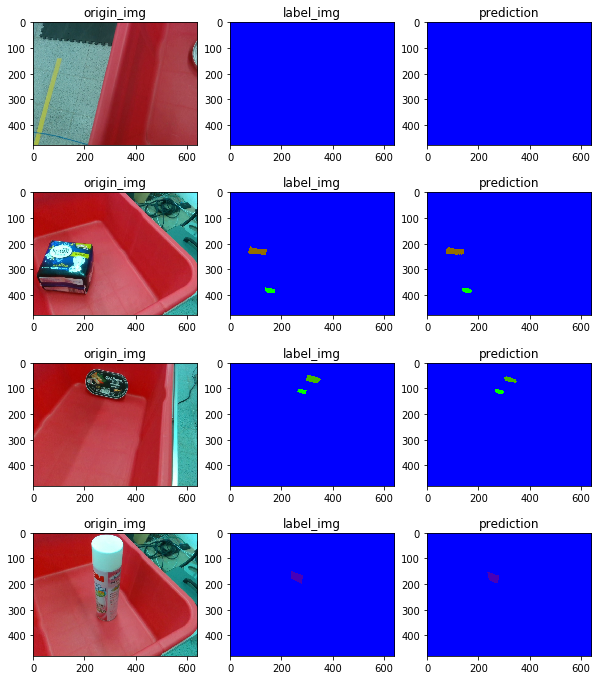

In [52]:
prediction("FCNs_barcode_batch6_epoch43_RMSprop_lr0.0001.pkl")

### HW: Plot three graphs: Training loss, class IOU curve, class F-score curve  

In [30]:
def draw_evaluation_curve(
    score_dir_path = score_dir, 
    f_score_filename="fscore_log.txt", 
    cls_iou_filename="cls_iou_log.txt", 
    loss_filename="loss_log.txt"):
    
    epoch = np.arange(0,45,1)
    color = ['red', 'green', 'blue']
    #brand = ['doublemint', 'kinder', 'kusan']
    
    plt.figure()
    for i in range(3):
        plt.title("0410757_fscore")
        plt.plot(epoch, fscore_l[:,i], color = color[i])  #, label = brand[i])
        plt.legend()
    plt.xlim(0,45)
    plt.figure()
    for i in range(3):
        plt.title("0410757_iou")
        plt.plot(epoch, iou_l[:,i], color = color[i])  #, label = brand[i])
        plt.legend()
    plt.xlim(0,45)
    plt.figure()
    plt.title("0410757_loss")
    plt.plot(epoch, loss_l, color = 'black', label = 'loss')
    plt.legend()
    plt.xlim(0,45)

/home/andyser/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


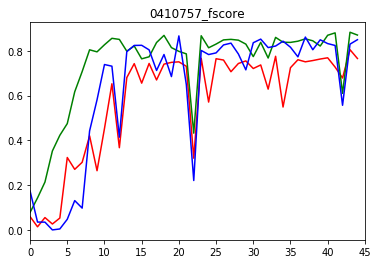

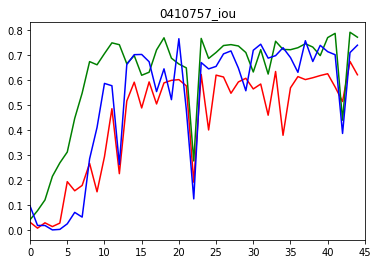

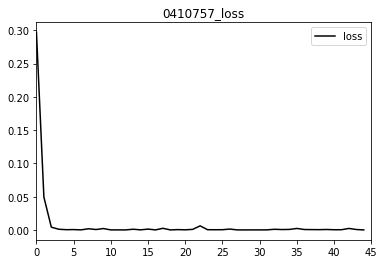

In [31]:
fscore_l = np.asarray(fscore_l)
iou_l = np.asarray(iou_l)
loss_l = np.asarray(loss_l)
draw_evaluation_curve()

In [53]:
# print(loss_l)
# print(fscore_l)

In [75]:
def test(model_name, data_path):
    state_dict = torch.load(os.path.join(model_dir, model_name))
    fcn_model.load_state_dict(state_dict)
    img        = cv2.imread(data_path,cv2.IMREAD_UNCHANGED)
    origin     = img
    img        = img[:, :, ::-1]  # switch to BGR

    img = np.transpose(img, (2, 0, 1)) / 255.
    img[0] -= means[0]
    img[1] -= means[1]
    img[2] -= means[2]

    # convert to tensor
    img = img[np.newaxis,:]
    img = torch.from_numpy(img.copy()).float() 
    output = fcn_model(img)
    output = output.data.cpu().numpy()

    N, _, h, w = output.shape
    pred = output.transpose(0, 2, 3, 1).reshape(-1, n_class).argmax(axis = 1).reshape(N, h, w)

    # show images
    
    img = img.numpy()
    for i in range(N):
        plt.figure()
        origin = cv2.cvtColor(origin, cv2.COLOR_BGR2RGB)
        plt.title("origin_img")
        plt.imshow(origin)
        plt.figure()
        plt.title("prediction")
        plt.imshow(pred[i],cmap = "brg",vmin = 0, vmax = n_class - 1)

    plt.show()

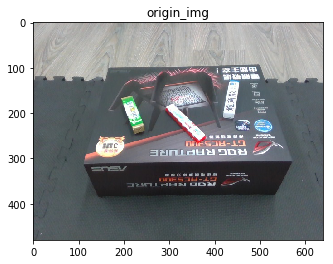

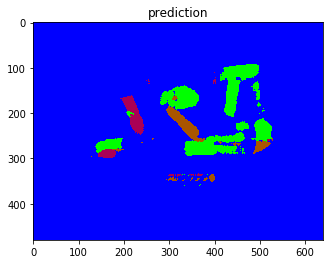

In [92]:
test("FCNs_mini_competition_batch10_epoch99_RMSprop_lr0.0001.pkl","data/test_log/frame-000015.jpg")